In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("../science.mplstyle")

from sklearn.utils import shuffle

import os


import pickle

from helpers.BDT import *
from helpers.data_transforms import inverse_transform, clean_data
from helpers.physics_functions import *
from helpers.plotting import hist_all_features_array
from helpers.evaluation import convert_to_latent_space, convert_to_latent_space_true_cathode

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
# selecting appropriate device
CUDA = torch.cuda.is_available()
print("cuda available:", CUDA)
device = torch.device("cuda" if CUDA else "cpu")


cuda available: True


In [21]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file)
    
    
config_id = "CATHODE_5"

configs_path = f"configs/{config_id}.yml"
with open(configs_path, "r") as file:
    flow_configs = yaml.safe_load(file)
    


# Load in data

In [22]:
# load in the data

bands = ["SBL", "SR", "SBH"]
data_dict = {}

working_dir = "/pscratch/sd/r/rmastand/dimuonAD/projects/logit_08_22/"
#\working_dir = "/global/u1/r/rmastand/dimuonAD/projects/powerscaler_0813/"


flow_id = "double_1"
particle_type = "eta"
project_id = f"lowmass_{particle_type}_nojet"


flow_training_dir = os.path.join(f"{working_dir}/models", f"{project_id}/{flow_id}/{config_id}")
#

with open(f"{flow_training_dir}/flow_samples", "rb") as infile: 
    data_dict = pickle.load(infile)
    
with open(f"{working_dir}/processed_data/{project_id}_test_band_data", "rb") as infile: 
    test_dict = pickle.load(infile)
    
with open(f"{working_dir}/processed_data/{project_id}_samesign_band_data", "rb") as infile: 
    samesign_dict = pickle.load(infile)
    

with open(f"{flow_training_dir}/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    print(configs)


feature_set = ['dimu_pt', 'dimu_eta', 'dimu_mass']



In [23]:
# Assemble the test set -- consists of both SB and SR

feature_set = ['dimu_pt', 'dimu_eta', 'dimu_mass']


num_events_test_SBL = test_dict["SBL"]["s_inj_data"]["dimu_mass"].shape[0]
num_events_test_SR = test_dict["SR"]["s_inj_data"]["dimu_mass"].shape[0]
num_events_test_SBH = test_dict["SBH"]["s_inj_data"]["dimu_mass"].shape[0]
num_events_samesign = samesign_dict["SR"]["s_inj_data"]["dimu_mass"].shape[0]+samesign_dict["SBH"]["s_inj_data"]["dimu_mass"].shape[0]+samesign_dict["SBL"]["s_inj_data"]["dimu_mass"].shape[0]

test_events_SBL = np.empty((num_events_test_SBL, len(feature_set)))
test_events_SR = np.empty((num_events_test_SR, len(feature_set)))
test_events_SBH = np.empty((num_events_test_SBH, len(feature_set)))

test_events_samesign = np.empty((num_events_samesign, len(feature_set)))

for i, feat in enumerate(feature_set):
    
    test_events_SBL[:,i] = test_dict["SBL"]["s_inj_data"][feat].reshape(-1,)
    test_events_SR[:,i] = test_dict["SR"]["s_inj_data"][feat].reshape(-1,)
    test_events_SBH[:,i] = test_dict["SBH"]["s_inj_data"][feat].reshape(-1,)
    
    
    loc_arr = np.concatenate((samesign_dict["SR"]["s_inj_data"][feat], samesign_dict["SBL"]["s_inj_data"][feat], samesign_dict["SBH"]["s_inj_data"][feat]))
    test_events_samesign[:,i] = loc_arr.reshape(-1,)

test_events_SB = np.vstack([test_events_SBL, test_events_SBH ])
print(data_dict["SR"].shape)
    
print(f"Total number of test events: {test_events_SR.shape[0]+test_events_SBL.shape[0]+test_events_SBH.shape[0]}. {test_events_SR.shape[0]} in SR, {test_events_SBL.shape[0]+test_events_SBH.shape[0]} in SB.")


(44191, 3)
Total number of test events: 39998. 3436 in SR, 36562 in SB.


0


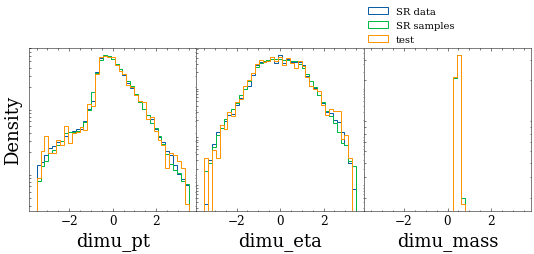

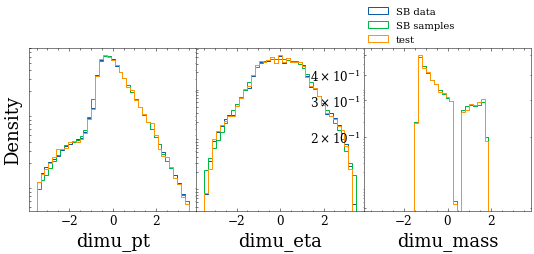

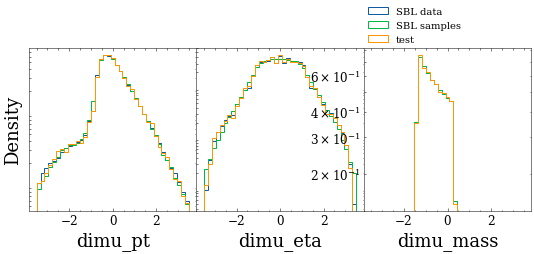

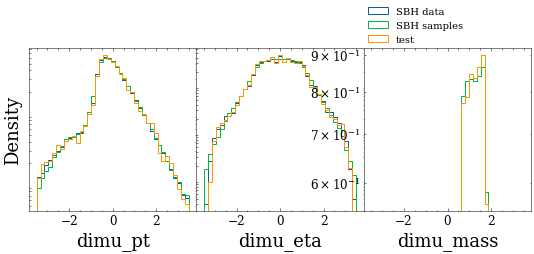

In [24]:
plot_bound = 3.5
log_scale = True

print(np.sum(np.isinf(data_dict["SB_samples"])))


hist_all_features_array([data_dict["SR"], data_dict["SR_samples"], test_events_SR], ["SR data", "SR samples", "test"], feature_set, plot_bound = plot_bound, yscale_log = log_scale)
hist_all_features_array([data_dict["SB"], data_dict["SB_samples"], test_events_SB], ["SB data", "SB samples", "test"], feature_set, plot_bound = plot_bound, yscale_log = log_scale)
hist_all_features_array([data_dict["SBL"], data_dict["SBL_samples"], test_events_SBL], ["SBL data", "SBL samples", "test"], feature_set, plot_bound = plot_bound, yscale_log = log_scale)
hist_all_features_array([data_dict["SBH"], data_dict["SBH_samples"],test_events_SBH], ["SBH data", "SBH samples", "test"], feature_set, plot_bound = plot_bound, yscale_log = log_scale)


SR_min_rescaled = np.min(test_events_SR[:,-1])
SR_max_rescaled = np.max(test_events_SR[:,-1])

## Convert data back to latent space

DensityEstimator has 1152 parameters
Loading model parameters from /pscratch/sd/r/rmastand/dimuonAD/projects/logit_08_22//models/lowmass_eta_nojet/double_1/CATHODE_5/flow_epoch_243.par
DensityEstimator has 1152 parameters
Loading model parameters from /pscratch/sd/r/rmastand/dimuonAD/projects/logit_08_22//models/lowmass_eta_nojet/double_1/CATHODE_5/flow_epoch_243.par
DensityEstimator has 1152 parameters
Loading model parameters from /pscratch/sd/r/rmastand/dimuonAD/projects/logit_08_22//models/lowmass_eta_nojet/double_1/CATHODE_5/flow_epoch_243.par
DensityEstimator has 1152 parameters
Loading model parameters from /pscratch/sd/r/rmastand/dimuonAD/projects/logit_08_22//models/lowmass_eta_nojet/double_1/CATHODE_5/flow_epoch_243.par
DensityEstimator has 1152 parameters
Loading model parameters from /pscratch/sd/r/rmastand/dimuonAD/projects/logit_08_22//models/lowmass_eta_nojet/double_1/CATHODE_5/flow_epoch_243.par
DensityEstimator has 1152 parameters
Loading model parameters from /pscratc

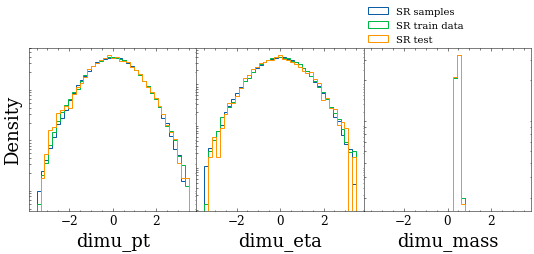

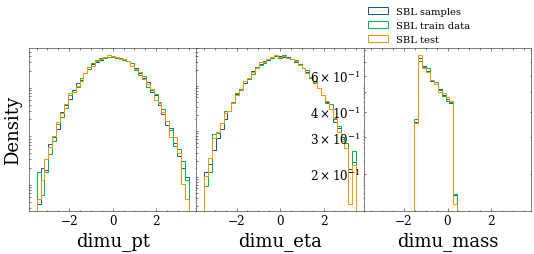

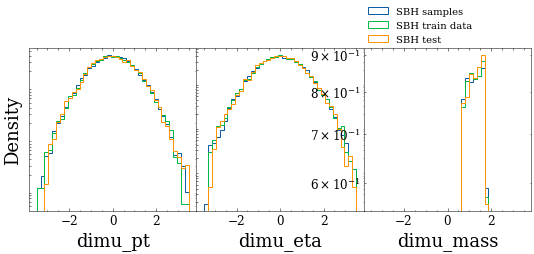

In [25]:
"""
SR_samples_latent = convert_to_latent_space(data_dict["SR_samples"], flow_training_dir, config_id, device)
SR_samples_validation_latent = convert_to_latent_space(data_dict["SR_samples_validation"], flow_training_dir, config_id, device)

SBL_samples_latent = convert_to_latent_space(data_dict["SBL_samples"][:30000], flow_training_dir, config_id, device)
SBH_samples_latent = convert_to_latent_space(data_dict["SBH_samples"][:30000], flow_training_dir, config_id, device)


SR_data_latent = convert_to_latent_space(data_dict["SR"], flow_training_dir, config_id, device) # only used for visualizing
SBL_data_latent = convert_to_latent_space(data_dict["SBL"][:10000], flow_training_dir, config_id, device) # only used for visualizing
SBH_data_latent = convert_to_latent_space(data_dict["SBH"][:10000], flow_training_dir, config_id, device) # only used for visualizing

SR_test_data_latent = convert_to_latent_space(test_events_SR, flow_training_dir, config_id, device) # only used for visualizing
SBL_test_data_latent = convert_to_latent_space(test_events_SBL, flow_training_dir, config_id, device) # only used for visualizing
SBH_test_data_latent = convert_to_latent_space(test_events_SBH, flow_training_dir, config_id, device) # only used for visualizing

samesign_data_latent = convert_to_latent_space(test_events_samesign, flow_training_dir, config_id, device) # only used for visualizing
"""

n_features = len(feature_set) - 1

SR_samples_latent = convert_to_latent_space_true_cathode(data_dict["SR_samples"], n_features, flow_training_dir, configs_path, device)
SR_samples_validation_latent = convert_to_latent_space_true_cathode(data_dict["SR_samples_validation"], n_features, flow_training_dir, configs_path, device)

SBL_samples_latent = convert_to_latent_space_true_cathode(data_dict["SBL_samples"][:30000], n_features, flow_training_dir, configs_path, device)
SBH_samples_latent = convert_to_latent_space_true_cathode(data_dict["SBH_samples"][:30000], n_features, flow_training_dir, configs_path, device)


SR_data_latent = convert_to_latent_space_true_cathode(data_dict["SR"], n_features, flow_training_dir, configs_path, device) # only used for visualizing
SBL_data_latent = convert_to_latent_space_true_cathode(data_dict["SBL"][:10000], n_features, flow_training_dir, configs_path, device) # only used for visualizing
SBH_data_latent = convert_to_latent_space_true_cathode(data_dict["SBH"][:10000], n_features, flow_training_dir, configs_path, device) # only used for visualizing

SR_test_data_latent = convert_to_latent_space_true_cathode(test_events_SR, n_features, flow_training_dir, configs_path, device) # only used for visualizing
SBL_test_data_latent = convert_to_latent_space_true_cathode(test_events_SBL, n_features, flow_training_dir, configs_path, device) # only used for visualizing
SBH_test_data_latent = convert_to_latent_space_true_cathode(test_events_SBH, n_features, flow_training_dir, configs_path, device) # only used for visualizing

samesign_data_latent = convert_to_latent_space_true_cathode(test_events_samesign, n_features, flow_training_dir, configs_path, device) # only used for visualizing



SB_test_data_latent = np.vstack([SBL_test_data_latent, SBH_test_data_latent])

hist_all_features_array([SR_samples_latent, SR_data_latent, SR_test_data_latent], ["SR samples", "SR train data", "SR test"], feature_set, plot_bound = plot_bound, yscale_log = log_scale)
hist_all_features_array([SBL_samples_latent, SBL_data_latent, SBL_test_data_latent], ["SBL samples", "SBL train data", "SBL test"], feature_set, plot_bound = plot_bound, yscale_log = log_scale)
hist_all_features_array([SBH_samples_latent, SBH_data_latent, SBH_test_data_latent], ["SBH samples", "SBH train data", "SBH test"], feature_set, plot_bound = plot_bound, yscale_log = log_scale)






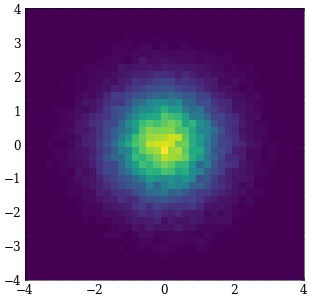

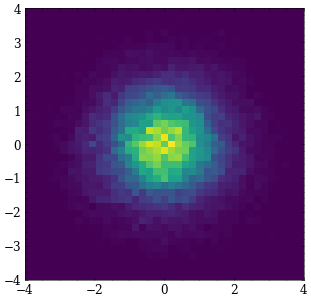

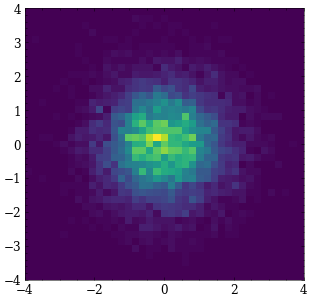

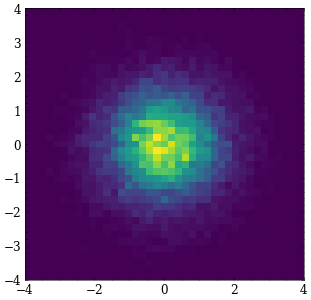

In [26]:
plt.figure(figsize = (5, 5))
plt.hist2d(SR_samples_latent[:,0], SR_samples_latent[:,1], bins = np.linspace(-4, 4, 40))
plt.show()

plt.figure(figsize = (5, 5))
plt.hist2d(SR_data_latent[:,0], SR_data_latent[:,1], bins = np.linspace(-4, 4, 40))
plt.show()

plt.figure(figsize = (5, 5))
plt.hist2d(SBL_data_latent[:,0], SBL_data_latent[:,1], bins = np.linspace(-4, 4, 40))
plt.show()

plt.figure(figsize = (5, 5))
plt.hist2d(SBL_test_data_latent[:,0], SBL_test_data_latent[:,1], bins = np.linspace(-4, 4, 40))
plt.show()

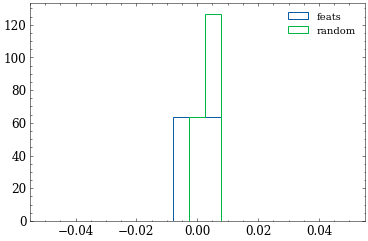

In [27]:

from scipy.stats import pearsonr
random = []
feats = []
n_features = len(feature_set)

for i in range(n_features):
    for j in range(i):
        
        feats.append(pearsonr(SR_samples_latent[:,i],SR_samples_latent[:,j]).statistic)
        random.append(pearsonr(np.random.normal(size=(SR_samples_latent.shape[0],)),np.random.normal(size=(SR_samples_latent.shape[0],))).statistic)
        
plt.figure()
plt.hist(feats, density = True, label = "feats", histtype = "step", bins = np.linspace(-0.05, 0.05, 20))
plt.hist(random, density = True, label = "random", histtype = "step", bins = np.linspace(-0.05, 0.05, 20))
plt.legend()
plt.show()

# Train networks

Train to discriminate (flow samples in SR) from (test data in SR)

In [28]:
import xgboost as xgb

# BDT HYPERPARAMETERS 

# best for feature set 3
n_estimators = 300 # number of boosting stages
max_depth = 3 # max depth of individual regression estimators; related to complexity
learning_rate = 0.075
subsample = 0.5 # fraction of samples to be used for fitting the individual base learners
early_stopping_rounds = 10 # stop training BDT is validation loss doesn't improve after this many rounds



In [29]:
def run_BDT_bump_hunt(flow_samples_SR, data_samples_SR, data_samples_SB, num_folds, num_to_ensemble, 
                      alt_test_sets_data={}, visualize=True):
    
    """
    Classifier is trained only on SR data, to distinguish flow SR samples from SR data
    
    Classifier is evaluated on test data from SR AND SB
    
    Note that alt test sets are NOT split into folds, since we aren't training on them. We do get diff scores for each fold
    """
    
    test_data_splits  = {i:0 for i in range(num_folds)}
    scores_splits = {i:0 for i in range(num_folds)}
    
    alt_scores_splits = {}
    for alt_id in alt_test_sets_data.keys():
        alt_scores_splits[alt_id] = {i:0 for i in range(num_folds)}
        
    # shuffle anything with SB data to mix the low and high masses before splitting 
    flow_samples_SR = shuffle(flow_samples_SR)
    data_samples_SR = shuffle(data_samples_SR)
    data_samples_SB = shuffle(data_samples_SB)
    
    flow_SR_splits = np.array_split(flow_samples_SR, num_folds)
    data_SR_splits = np.array_split(data_samples_SR, num_folds)
    data_SB_splits = np.array_split(data_samples_SB, num_folds) 
    
    for i_fold in range(num_folds):
            
        print(f"Fold {i_fold}:")
        
        """
        ASSEMBLE THE TRAIN / VAL / TEST DATA
        """
        
        # Assemble the train / test data
        training_data, training_labels = [], []
        validation_data, validation_labels = [], []
        testing_data = []

        for ii in range(num_folds):
            
            # test set comprised of SR and SB data
            if ii == i_fold:
                testing_data.append(data_SR_splits[ii])
                testing_data.append(data_SB_splits[ii])
                
            # validation set: flow SR samples, data SR sampkes
            elif ((ii+1)%num_folds) == i_fold:
                validation_data.append(flow_SR_splits[ii])
                validation_labels.append(np.zeros((flow_SR_splits[ii].shape[0],1)))
                validation_data.append(data_SR_splits[ii])
                validation_labels.append(np.ones((data_SR_splits[ii].shape[0],1)))
                
            else:
                training_data.append(flow_SR_splits[ii])
                training_labels.append(np.zeros((flow_SR_splits[ii].shape[0],1)))
                training_data.append(data_SR_splits[ii])
                training_labels.append(np.ones((data_SR_splits[ii].shape[0],1)))
                
        X_train_fold = np.concatenate(training_data)
        Y_train_fold = np.concatenate(training_labels)
        X_val_fold = np.concatenate(validation_data)
        Y_val_fold = np.concatenate(validation_labels)
        
        X_test_fold = np.concatenate(testing_data)
        
        # record the local fold data
        test_data_splits[i_fold] = X_test_fold
     
        """
        SORT THE WEIGHTS OUT
        """
        
        # First do the weights for the regular BC (non-decorr)
        class_weight = {0: 1, 1: sum(Y_train_fold==0)[0]/sum(Y_train_fold==1)[0]}
        class_weights_train = class_weight[0]*(1.0-Y_train_fold)+class_weight[1]*Y_train_fold
        class_weights_val = class_weight[0]*(1.0-Y_val_fold)+class_weight[1]*Y_val_fold
        
        """
        COMBINE W/ DECORRELATED TRAINING
        """
        # we only want to train on the non-mass features

        X_train_fold = X_train_fold[:,:-1]
        X_val_fold = X_val_fold[:,:-1]

        w_train_fold = class_weights_train
        w_val_fold = class_weights_val

        # shuffle for good measure
        X_train_fold, Y_train_fold, w_train_fold = shuffle(X_train_fold, Y_train_fold, w_train_fold)
        X_val_fold, Y_val_fold, w_val_fold = shuffle(X_val_fold, Y_val_fold, w_val_fold)
        
        X_test_fold = X_test_fold[:,:-1]
        
        
        print(f"X train shape: {X_train_fold.shape}, Y train shape: {Y_train_fold.shape}, w train shape: {w_train_fold.shape}.")
        print(f"X val shape: {X_val_fold.shape}, Y val shape: {Y_val_fold.shape}, w val shape: {w_val_fold.shape}.")
        print(f"X test shape: {X_test_fold.shape}." )
        
        """
        INITIALIZE SCORE OBJECTS
        """
        scores_fold = np.empty((X_test_fold.shape[0], num_to_ensemble))
        alt_scores_fold = {}
        for alt_id in alt_test_sets_data.keys():
            alt_scores_fold[alt_id] = np.empty((alt_test_sets_data[alt_id].shape[0], num_to_ensemble))
            
   
        """
        TRAIN ENSEMBLE OF TREES
        """
    
        if visualize:
            plt.figure()
        
        for i_tree in range(num_to_ensemble):
            
            print("   Network number:", i_tree)
            random_seed = i_fold*num_to_ensemble + i_tree + 1
                
                
            eval_set = [(X_train_fold, Y_train_fold), (X_val_fold, Y_val_fold)]

            bst_i = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, 
                              subsample=subsample,  early_stopping_rounds=early_stopping_rounds,
                              objective='binary:logistic', 
                                      random_state = random_seed, eval_metric="logloss")

            bst_i.fit(X_train_fold, Y_train_fold, sample_weight=w_train_fold, 
                      eval_set=eval_set, sample_weight_eval_set = [w_train_fold, w_val_fold],
                      verbose=False)
            results_f = bst_i.evals_result()
            losses = results_f["validation_0"]["logloss"]
            losses_val = results_f["validation_1"]["logloss"]
            best_epoch = bst_i.best_iteration


            # get scores
            scores_fold[:,i_tree] = bst_i.predict_proba(X_test_fold, iteration_range=(0,bst_i.best_iteration))[:,1]
            for alt_id in alt_test_sets_data.keys():
                alt_scores_fold[alt_id][:,i_tree] = bst_i.predict_proba(alt_test_sets_data[alt_id][:,:-1], iteration_range=(0,bst_i.best_iteration))[:,1]


            
            if visualize:
                
                plt.plot(losses, label = f"{i_tree}", color = f"C{i_tree}")
                plt.plot(losses_val, color = f"C{i_tree}", linestyle = "dashed")
                plt.xlabel("Epochs")
                plt.ylabel("Loss")
                plt.axvline(best_epoch, color = f"C{i_tree}")
                plt.title(f"Fold {i_fold}")
        
        if visualize:
            plt.legend()
            plt.show()
        
            
            
        """
        AVERAGE OVER ENSEMBLE
        """
        
        
            
        scores_splits[i_fold] = np.mean(scores_fold, axis = 1)
        for alt_id in alt_test_sets_data.keys():
            alt_scores_splits[alt_id][i_fold] = np.mean(alt_scores_fold[alt_id], axis = 1)
            
        plt.figure()
        plt.hist2d(test_data_splits[i_fold][:,-1], scores_splits[i_fold], bins = 40, cmap = "hot", density = True)
        plt.xlabel("M (rescaled)")
        plt.ylabel("score")
        #plt.axvline(SR_min_rescaled, color = "red")
        #plt.axvline(SR_max_rescaled, color = "red")
        plt.colorbar()
        plt.show()
        
        plt.figure()
        plt.hist2d(alt_test_sets_data["FPR_validation"][:,-1], alt_scores_splits["FPR_validation"][i_fold], bins = 40, cmap = "hot", density = True)
        plt.xlabel("M (rescaled)")
        plt.ylabel("score")
        #plt.axvline(SR_min_rescaled, color = "red")
        #plt.axvline(SR_max_rescaled, color = "red")
        plt.title("FPR_validation")
        plt.colorbar()
        plt.show()
        
        plt.figure()
        plt.hist2d(alt_test_sets_data["samesign"][:,-1], alt_scores_splits["samesign"][i_fold], bins = 40, cmap = "hot", density = True)
        plt.xlabel("M (rescaled)")
        plt.ylabel("score")
        #plt.axvline(SR_min_rescaled, color = "red")
        #plt.axvline(SR_max_rescaled, color = "red")
        plt.title("samesign")
        plt.colorbar()
        plt.show()
            
        print()


    return test_data_splits, scores_splits, alt_scores_splits




Fold 0:
X train shape: (28575, 2), Y train shape: (28575, 1), w train shape: (28575, 1).
X val shape: (9525, 2), Y val shape: (9525, 1), w val shape: (9525, 1).
X test shape: (8001, 2).
   Network number: 0
   Network number: 1
   Network number: 2
   Network number: 3
   Network number: 4
   Network number: 5
   Network number: 6
   Network number: 7
   Network number: 8
   Network number: 9


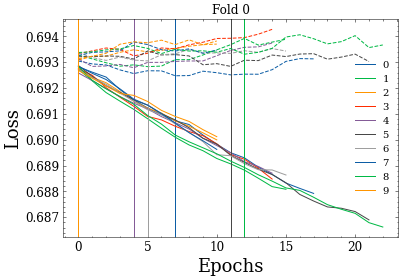

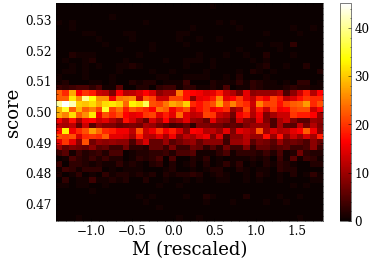

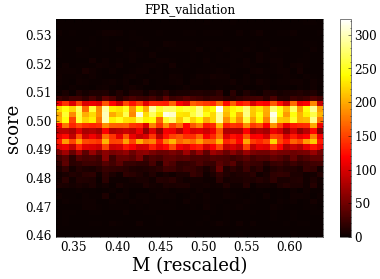

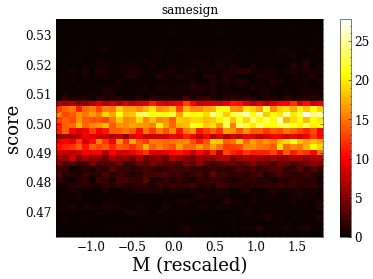


Fold 1:
X train shape: (28575, 2), Y train shape: (28575, 1), w train shape: (28575, 1).
X val shape: (9527, 2), Y val shape: (9527, 1), w val shape: (9527, 1).
X test shape: (8000, 2).
   Network number: 0
   Network number: 1
   Network number: 2
   Network number: 3
   Network number: 4
   Network number: 5
   Network number: 6
   Network number: 7
   Network number: 8
   Network number: 9


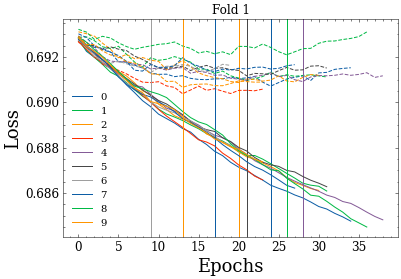

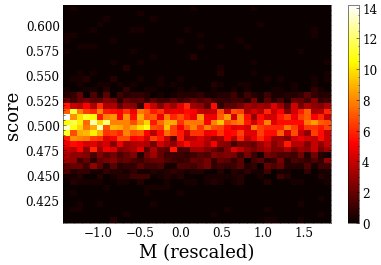

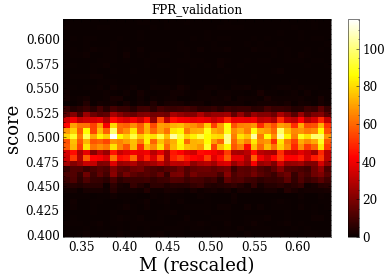

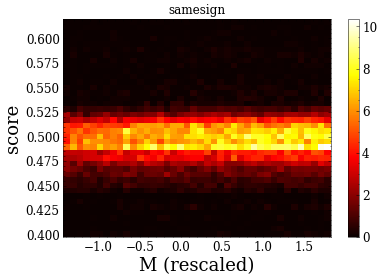


Fold 2:
X train shape: (28577, 2), Y train shape: (28577, 1), w train shape: (28577, 1).
X val shape: (9525, 2), Y val shape: (9525, 1), w val shape: (9525, 1).
X test shape: (7999, 2).
   Network number: 0
   Network number: 1
   Network number: 2
   Network number: 3
   Network number: 4
   Network number: 5
   Network number: 6
   Network number: 7
   Network number: 8
   Network number: 9


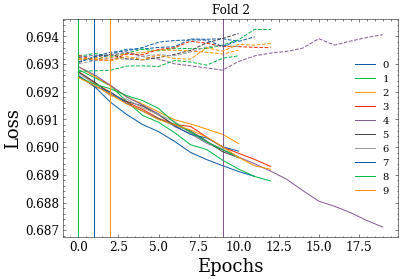

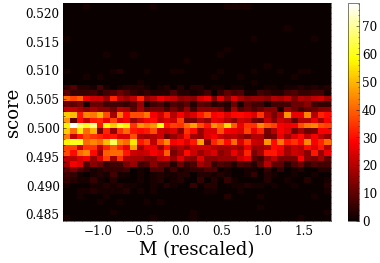

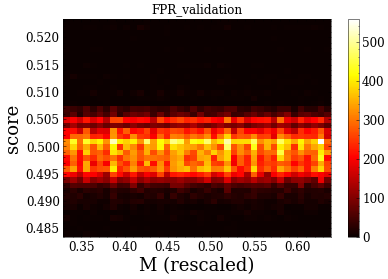

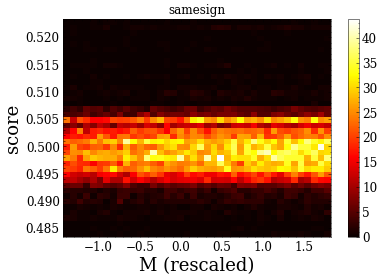


Fold 3:
X train shape: (28577, 2), Y train shape: (28577, 1), w train shape: (28577, 1).
X val shape: (9525, 2), Y val shape: (9525, 1), w val shape: (9525, 1).
X test shape: (7999, 2).
   Network number: 0
   Network number: 1
   Network number: 2
   Network number: 3
   Network number: 4
   Network number: 5
   Network number: 6
   Network number: 7
   Network number: 8
   Network number: 9


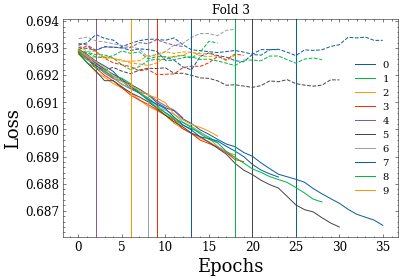

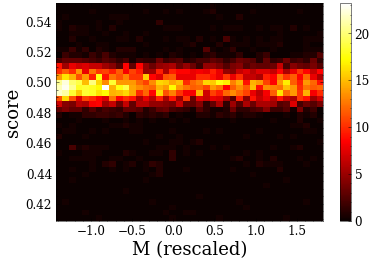

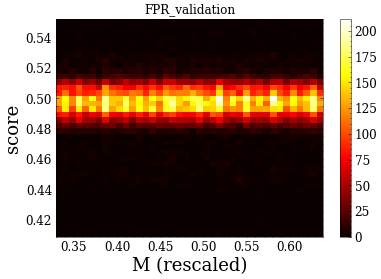

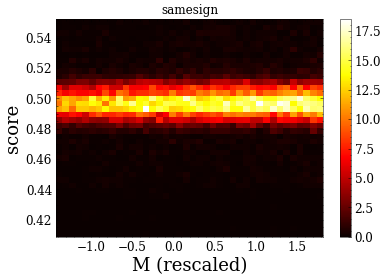


Fold 4:
X train shape: (28577, 2), Y train shape: (28577, 1), w train shape: (28577, 1).
X val shape: (9525, 2), Y val shape: (9525, 1), w val shape: (9525, 1).
X test shape: (7999, 2).
   Network number: 0
   Network number: 1
   Network number: 2
   Network number: 3
   Network number: 4
   Network number: 5
   Network number: 6
   Network number: 7
   Network number: 8
   Network number: 9


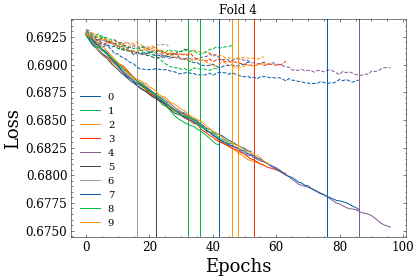

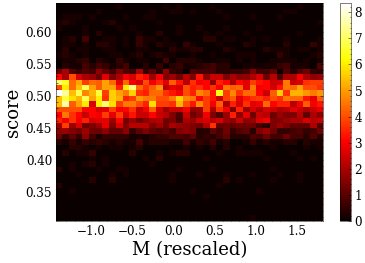

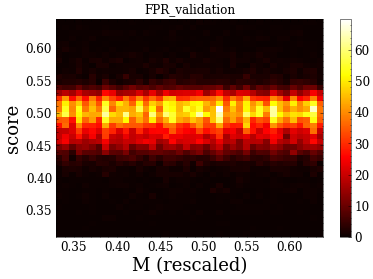

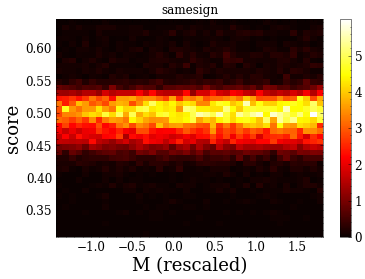

In [30]:
# Train a classifier to discriminate SR samples from SR data

n_folds = 5
n_to_ensemble = 10




test_data_splits, scores_splits, alt_scores_splits = run_BDT_bump_hunt(clean_data(SR_samples_latent), 
                                        clean_data(SR_test_data_latent), clean_data(SB_test_data_latent), n_folds, n_to_ensemble, 
                                            alt_test_sets_data = {"FPR_validation":SR_samples_validation_latent,"samesign":samesign_data_latent},
                                                                     visualize=True)



## Analysis


### True bump hunt

- Define a polynomial form for the background fit
- For each cut on the classifier score:
  - Fit the background on the cut SB data
  - Estimate N_bkg
  - Calculate S/B, S/sqrt(B)



In [31]:
with open(f"{working_dir}/processed_data/mass_scaler_{particle_type}", "rb") as ifile:
    scaler = pickle.load(ifile)
    
sorted_masses_splits = {}

fpr_thresholds = [1, 0.25, 0.1, 0.05, 0.01]
score_cutoffs = {i:[] for i in range(n_folds)}


for i_fold in range(n_folds):
    for t in fpr_thresholds:
        
        loc_scores_sorted = np.sort(1.0-alt_scores_splits["FPR_validation"][i_fold])
        score_cutoff = 1-loc_scores_sorted[min(int(t*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
        score_cutoffs[i_fold].append(score_cutoff)  


1 [1. 1. 1. 1. 1.]
200.04144983052993 3235.95855016947
0.25 [0.25707274 0.25398085 0.27762593 0.23973263 0.26768055]
70.01071015536672 823.9892898446333
0.1 [0.10355075 0.10622009 0.12610483 0.1110087  0.10552777]
32.54384903336978 350.4561509666302
0.05 [0.05817523 0.05587332 0.08124831 0.05733448 0.06668321]
22.233854109604067 198.76614589039593
0.01 [0.01498108 0.0097269  0.0175521  0.01723482 0.01688339]
12.032425828725806 40.967574171274194



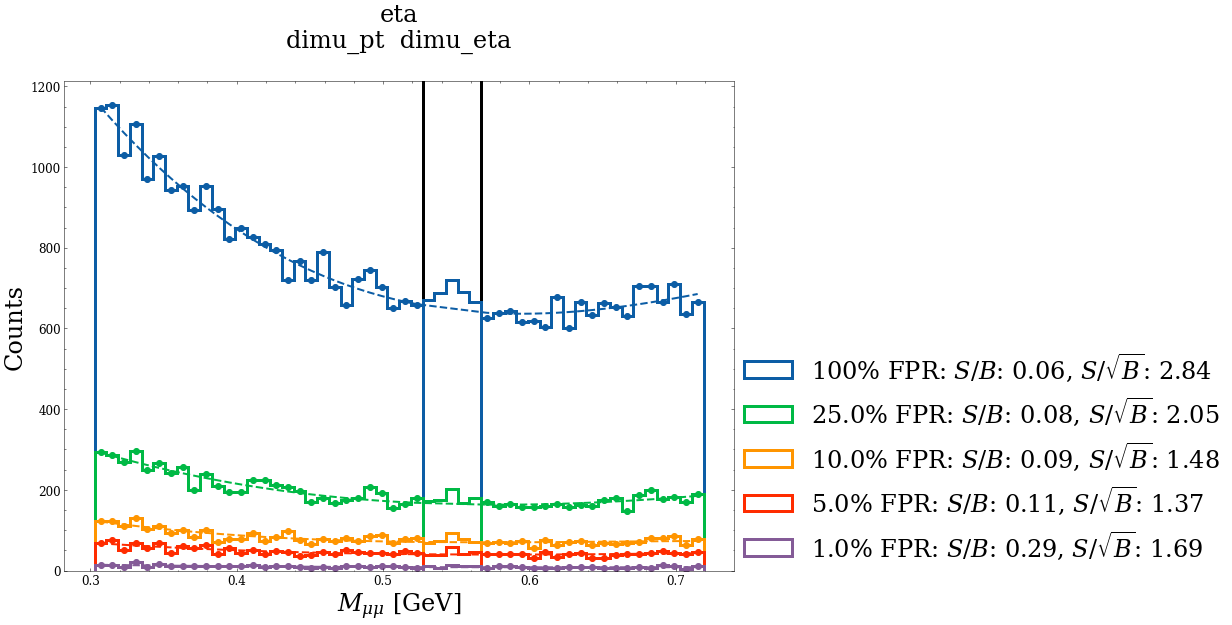

In [32]:
SB_left = float(workflow[particle_type]["SB_left"])
SR_left = float(workflow[particle_type]["SR_left"])
SR_right = float(workflow[particle_type]["SR_right"])
SB_right = float(workflow[particle_type]["SB_right"])
    


remove_edge = True

    
    
x = np.linspace(SB_left, SB_right, 100)

# get bins, bin centers
plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, remove_edge)

fit_type = "cubic"

if fit_type == "cubic": fit_function = bkg_fit_cubic
elif fit_type == "quintic": fit_function = bkg_fit_quintic
elif fit_type == "ratio": fit_function = bkg_fit_ratio



plt.figure(figsize = (12, 9))
for t, threshold in enumerate(fpr_thresholds):
    
    # corrections to SR / SB efficiencies
    SBL_eff, SBH_eff, SR_eff = 0, 0, 0
    filtered_masses = []
    
    for i_fold in range(n_folds):
        
        loc_true_masses = scaler.inverse_transform(np.array(test_data_splits[i_fold][:,-1]).reshape(-1,1))
        #loc_true_masses = inverse_transform(np.array(test_data_splits[i_fold][:,-1]).reshape(-1,1), scaler)
        loc_filtered_masses, loc_SBL_eff, loc_SBH_eff, loc_SR_eff = select_top_events_fold(loc_true_masses, scores_splits[i_fold], score_cutoffs[i_fold][t],
                                                                                           plot_bins_left, plot_bins_right, plot_bins_SR)
        
        filtered_masses.append(loc_filtered_masses)
        SBL_eff += loc_SBL_eff
        SBH_eff += loc_SBH_eff
        SR_eff += loc_SR_eff
        

    filtered_masses = np.concatenate(filtered_masses)

    SBL_rescale = None#threshold/(SBL_eff/n_folds)
    SBH_rescale = None#threshold/(SBH_eff/n_folds)
    print(threshold, SR_eff/n_folds)
    
    
    # get the fit function to SB background
    popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_all, SBL_rescale=SBL_rescale, SBH_rescale=SBH_rescale)
    #print("chi2/dof:", chi2/n_dof)
    # plot the fit function
    plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    
    
    # calculate significance of bump
    num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, SR_left, SR_right, popt)
    print(num_S_expected_in_SR, num_B_expected_in_SR)

    y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
    B_error = np.sum(y_err)

    label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(num_S_expected_in_SR/num_B_expected_in_SR,2))+", $S/\sqrt{B}$: "+str(round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2),2))

    plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string)
    plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")
    
    

print() 
plt.legend(loc = (1, 0), fontsize = 24)


plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)

plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
plt.ylabel("Counts", fontsize = 24)
plt.title(f"{particle_type}\n"+"  ".join(feature_set[:-1])+"\n", fontsize = 24)
plt.show()





Repeat for samesign background

1 [1. 1. 1. 1. 1.]
0.25 [0.25568369 0.24852686 0.25902141 0.25386997 0.2631746 ]
0.1 [0.11235585 0.1254766  0.1293578  0.12198142 0.11206349]
0.05 [0.06655684 0.08214905 0.07981651 0.07368421 0.06952381]
0.01 [0.01812191 0.02738302 0.02568807 0.02693498 0.02444444]


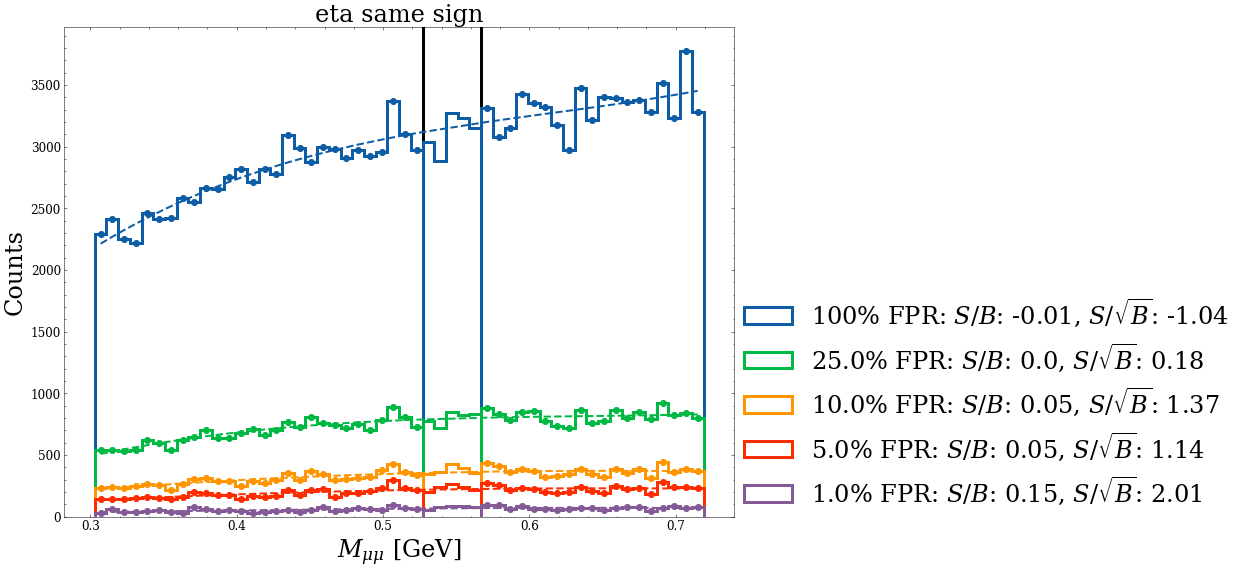

In [33]:

plt.figure(figsize = (12, 9))
for t, threshold in enumerate(fpr_thresholds):
    
    # corrections to SR / SB efficiencies
    SBL_eff, SBH_eff, SR_eff = 0, 0, 0
    filtered_masses = []
    
    for i_fold in range(n_folds):
        
        loc_true_masses = scaler.inverse_transform(test_events_samesign[:,-1].reshape(-1,1))
        #loc_true_masses = inverse_transform(test_events_samesign[:,-1].reshape(-1,1), scaler)
        loc_filtered_masses, loc_SBL_eff, loc_SBH_eff, loc_SR_eff = select_top_events_fold(loc_true_masses, alt_scores_splits["samesign"][i_fold], score_cutoffs[i_fold][t],
                                                                                           plot_bins_left, plot_bins_right, plot_bins_SR)
        
        filtered_masses.append(loc_filtered_masses)
        SBL_eff += loc_SBL_eff
        SBH_eff += loc_SBH_eff
        SR_eff += loc_SR_eff
        
        
    filtered_masses = np.concatenate(filtered_masses)
    
    SBL_rescale = None#threshold/(SBL_eff/n_folds)
    SBH_rescale = None#threshold/(SBH_eff/n_folds)
    print(threshold, SR_eff/n_folds)
    
    
    # get the fit function to SB background
    popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_all, SBL_rescale=SBL_rescale, SBH_rescale=SBH_rescale)
    #print("chi2/dof:", chi2/n_dof)
    # plot the fit function
    plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    
    
    # calculate significance of bump
    num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, SR_left, SR_right, popt)
    #print(num_S_expected_in_SR, num_B_expected_in_SR)

    y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
    B_error = np.sum(y_err)

    label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(num_S_expected_in_SR/num_B_expected_in_SR,2))+", $S/\sqrt{B}$: "+str(round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2),2))

    plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string)
    plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")
    
    
    
    
#plt.title(",  ".join(feature_set[:-1])+"\n", fontsize = 18) 
plt.legend(loc = (1, 0), fontsize = 24)
#plt.yscale("log")

plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)

plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
plt.ylabel("Counts", fontsize = 24)
plt.title(f"{particle_type} same sign", fontsize = 24)

plt.show()